# Neural network hidden layers activation embedding

Eryk Sikora <br>
Krzysztof Tylka-Suleja<br>
Aleksandra Pestka

#### In this notebook we will use fully connected neural network for a classification task to improve visualizations algorithm from previous classes.

In the fully connected neural network, the output of each layer is computed using the activations from the previous one. In neural network training process, each successive layer learns to extract features from data with increasingly higher levels of abstraction. In this exercise, instead of directly visualizing data, we'll try to visualize the activation of hidden layers in neural networks. Using this idea, we can improve the process of data visualization, and on the other hand, see how processing this data looks like by a neural network.

In the first stage, we define simple architecture of the neural network and train it to recognize digits in the MNIST dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD
from keras import backend as K

from keras.datasets import mnist
from keras.utils import np_utils
from sklearn.model_selection import train_test_split


%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"

In [2]:
nb_classes = 10

The dropout layers have the very specific function to drop out a random set of activations in that layers by setting them to zero in the forward pass. Simple as that.
It allows to avoid overfitting but has to be used only at training time and not at test time.

In [3]:
# set dropout rate - fractions of neurons to drop

dropout = 0.5

In [4]:
# build very simple neural network with 2 hidden layers

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(784,)))
model.add(Dropout(dropout))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [5]:
# The binary_crossentropy loss expects a one-hot-vector as input,
# so we apply the to_categorical function from keras.utilis to convert integer labels to one-hot-vectors.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Put everything on grayscale
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)


In [8]:
# split training and validation data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=5/6)

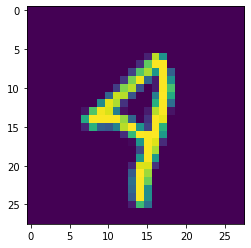

In [9]:
# show example digit
plt.imshow(X_train[0].reshape(28, 28))

In [10]:
# When we have defined and compiled the model, it can be trained using the fit function.
# We also use validation dataset to monitor validation loss and accuracy.

network_history = model.fit(X_train, Y_train, batch_size=128, 
                            epochs=20, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/20
391/391 [==============================] - 3s 6ms/step - loss: 1.0862 - accuracy: 0.6400 - val_loss: 0.2011 - val_accuracy: 0.9398
Epoch 2/20
391/391 [==============================] - 2s 5ms/step - loss: 0.3336 - accuracy: 0.9064 - val_loss: 0.1497 - val_accuracy: 0.9572
Epoch 3/20
391/391 [==============================] - 2s 5ms/step - loss: 0.2531 - accuracy: 0.9289 - val_loss: 0.1210 - val_accuracy: 0.9631
Epoch 4/20
391/391 [==============================] - 2s 5ms/step - loss: 0.2130 - accuracy: 0.9398 - val_loss: 0.1061 - val_accuracy: 0.9669
Epoch 5/20
391/391 [==============================] - 4s 11ms/step - loss: 0.1876 - accuracy: 0.9477 - val_loss: 0.0939 - val_accuracy: 0.9710
Epoch 6/20
391/391 [==============================] - 2s 5ms/step - loss: 0.1730 - accuracy: 0.9508 - val_loss: 0.0913 - val_accuracy: 0.9704
Epoch 7/20
391/391 [==============================] - 2s 6ms/step - loss: 0.1533 - accuracy: 0.9566 - val_loss: 0.0869 - val_accuracy: 0.9735
Epoch

In [11]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

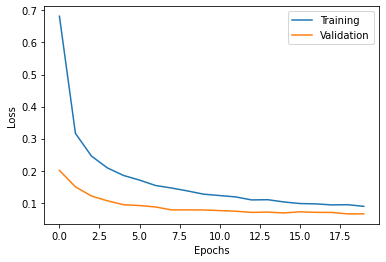

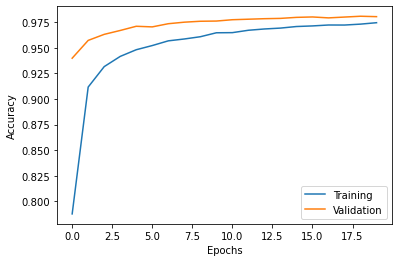

In [12]:
# fit function return keras.callbacks.History object which contains the entire history
# of training/validation loss, accuracy and other metrices for each epoch.
# We can therefore plot the behaviour of loss and accuracy during the training phase.

plot_history(network_history)

In [13]:
# Keras Model have summary function, that print data about model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


In [14]:
# We are interested in downloading the activation of hidden layers, because the dropout layers are between them,
# we need to properly select the index of the three dense layers.

get_layer_output = K.function([model.layers[0].input],
                              [model.layers[0].output, model.layers[2].output, model.layers[4].output])

layer1_output, layer2_output, layer3_output = get_layer_output([X_train])

In [15]:
train_ids = [np.arange(len(Y_train))[Y_train[:,i] == 1] for i in range(10)]

The 2 graphs below are not directly related to the topic of the exercise, but they visualize very well how neuron activation actives work and for explanation are included.

In [16]:
%%capture
%matplotlib inline

# this animation shows what the example number 5 looks like
# and what activations of neurons look in hidden layers of the neural network



# digit to be plotted
digit = 5

# indices of frames to be plotted for this digit
n = range(50)

# initialize plots
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))

# prepare plots
ax1.set_title('Input Layer', fontsize=16)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax2.set_title('Hidden Layer 1', fontsize=16)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

ax3.set_title('Hidden Layer 2', fontsize=16)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
    
ax4.set_title('Output Layer', fontsize=16)
ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)   

# add numbers to the output layer plot to indicate label
for i in range(3):
    for j in range(4):
        text = ax4.text(j, i, [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, '', '']][i][j],
                        ha="center", va="center", color="w", fontsize=16)    
        
def animate(id):
    # plot elements that are changed in the animation
    digit_plot = ax1.imshow(X_train[train_ids[digit][id]].reshape((28,28)), animated=True)
    layer1_plot = ax2.imshow(layer1_output[train_ids[digit][id]].reshape((16,16)), animated=True)
    layer2_plot = ax3.imshow(layer2_output[train_ids[digit][id]].reshape((8,8)), animated=True)
    output_plot = ax4.imshow(np.append(layer3_output[train_ids[digit][id]], 
                                       [np.nan, np.nan]).reshape((3,4)), animated=True)
    return digit_plot, layer1_plot, layer2_plot, output_plot,

# define animation
ani = matplotlib.animation.FuncAnimation(f, animate, frames=n, interval=100)

In [17]:
ani

In most cases the same subset of neurons fires, while other neurons remain quiescent. This is much more obvious in the second hidden layer than in the first hidden layer and can be interpreted as the first layer pre-processesing the pixel data, while the second layer deals with pattern recognition.

This effect is mainly caused by regularization forced by dropout. Dropout generally leads to the sparse weight matrices where a significant part of connection weights are close to 0. Insignificant weights are suppressed.


Optional, nonobligatory task:
You can easily see how the visualizations change if you comment lines responsible for the dropout "model.add(Dropout(dropout))".
Remember to change "get_layer_output", because after removing the dropout, the dense layers will have indexes: 0,1,2.


In [18]:
%%capture
%matplotlib inline


# Let's check the similarity in behavior for frames showing the same digit by looking at the ensemble properties.
# In this case, ensemble properties refers to how the neurons behave on average
# for a large number of frames showing the same digit.

# digit to be plotted
digit = 6

# numbers of frames to be summed over
n = np.append([1], np.linspace(5, 100, 20, dtype=int))

# initialize plots
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))

# add a counter indicating the number of frames used in the summation
counter = ax1.text(1, 2, 'n={}'.format(0), color='white', fontsize=16, animated=True)

# prepare plots
ax1.set_title('Input Layer', fontsize=16)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax2.set_title('Hidden Layer 1', fontsize=16)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

ax3.set_title('Hidden Layer 2', fontsize=16)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
    
ax4.set_title('Output Layer', fontsize=16)
ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)   

# add numbers to the output layer plot to indicate label
for i in range(3):
    for j in range(4):
        text = ax4.text(j, i, [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, '', '']][i][j],
                        ha="center", va="center", color="w", fontsize=16)    
        
def animate(id):
    # plot elements that are changed in the animation
    digit_plot = ax1.imshow(np.sum(X_train[train_ids[digit][:id]], axis=0).reshape((28,28)), animated=True)
    layer1_plot = ax2.imshow(np.sum(layer1_output[train_ids[digit][:id]], axis=0).reshape((16,16)), animated=True)
    layer2_plot = ax3.imshow(np.sum(layer2_output[train_ids[digit][:id]], axis=0).reshape((8,8)), animated=True)
    output_plot = ax4.imshow(np.append(np.sum(layer3_output[train_ids[digit][:id]], axis=0), 
                                       [np.nan, np.nan]).reshape((3,4)), animated=True)
    counter.set_text('n={}'.format(id))
    return digit_plot, layer1_plot, layer2_plot, output_plot, counter,

# define animation
ani = matplotlib.animation.FuncAnimation(f, animate, frames=n, interval=100)

In [19]:
ani

After summing up the responses of as little as 20-30 frames, the pattern in the second hidden layer is almost static. After combining about 70-80 frames, also the pattern in the first hidden layer appears static. This supports the idea that only a subset of all neurons is involved in the recognition of individual digits.

Especially the above plot is important when we think about use of neural networks for data visualization. We can clearly see that the activation generated by examples belonging to the same class are less chaotic than the examples themselves, therefore their visualization should give a more clustered structure

# Homework

- project a mnist training part into 2-dimensional space using t-SNE and UMAP.

- use layer1_output and layer2_output to project first and second hidden layers of neural network into a 2-dimensional space. Also divided into a test and training set, use the same methods as the point above.

- also visualize the test part.

- Try to use 2-dimensional projection for classification task.

- Use embeddings lerned on raw train data (and also on hidden activations of train data) to transform test data (and also hidden activations of test data) into 2-dimensional space.

- Use the k-nearest neighbors algorithm to classify transformed points from the test set. Use the KNN algorithm in which you will use points from the training set as a neighbor with known class assignment. Becouse t-SNE is a non-linear, non-parametric embedding you cant use already learned t-SNE to transform new points into the existing embedded space. So for this part, use only UMAP with have fit_transform method (learn manifold) and also transform (only project new data to existing manifold). Try with few values of n_neighbors e.g [3, 5, 10]

- Estimate the accuracy of classification using this approach. Use all 3 layers (raw data, 1 hidden layer, 2 hidden layer) and few values of n_neighbors

## UMAP and TSNE

**Metoda umożliwająca wizualizację danych przetworzonych przy użyciu UMAP i t-SNE.**

In [20]:
import umap
from sklearn.manifold import TSNE

def method_vis(embedding, target, title, custom_labels=None):
    fig, ax = plt.subplots(figsize=(12, 10))
    target = np.argmax(target, axis=1) # inverse of 'to_categorical' function
    color = target.astype(int)
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
    
    if custom_labels is not None:
        cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
        cbar.set_ticks(np.arange(10))
        cbar.set_ticklabels(custom_labels)
    else:
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Classes")
        ax.add_artist(legend)
    
    plt.title(f"{title}", fontsize=18)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### UMAP

**Wizualizacja częsci treningowej i testowej danych wejściowych przetworzonych przy użyciu UMAP**

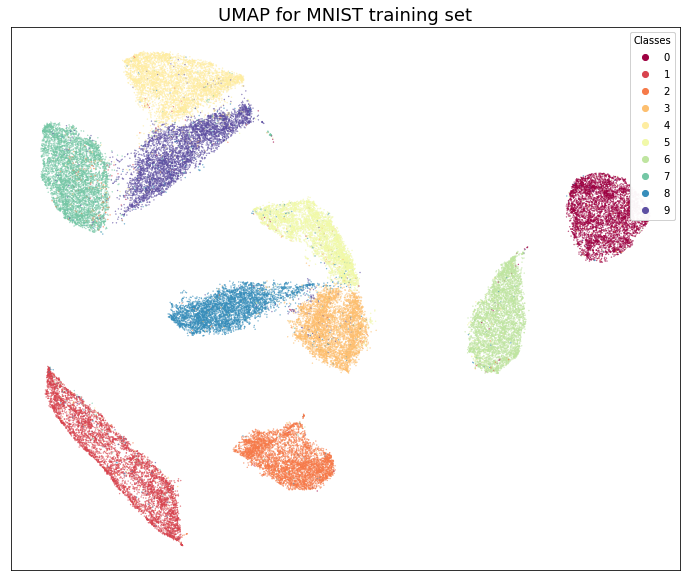

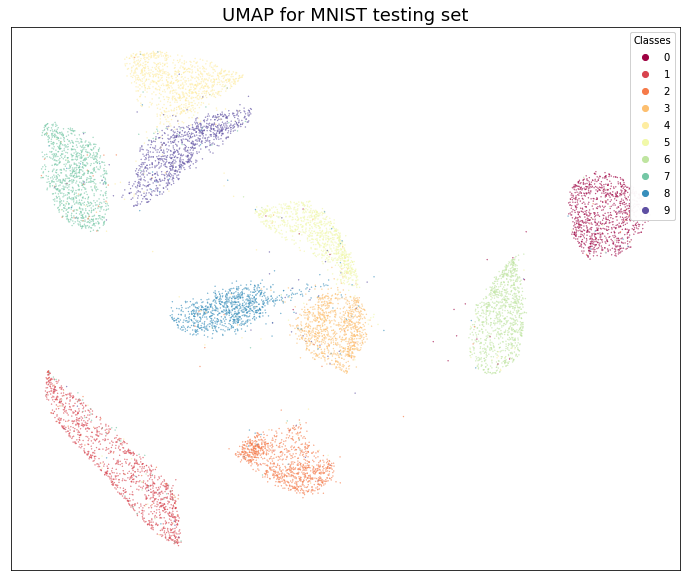

In [21]:
reducer_umap_mnist = umap.UMAP(random_state=42)
embedding_umap_mnist = reducer_umap_mnist.fit_transform(X_train) # learn manifold 
embedding_umap_mnist_test = reducer_umap_mnist.transform(X_test) # project new data to existing manifold

method_vis(embedding_umap_mnist, Y_train, 'UMAP for MNIST training set')
method_vis(embedding_umap_mnist_test, Y_test, 'UMAP for MNIST testing set')

Wizualizacja pokazuje dobrą seperację pomiędzy większością klas, jednak klasy odpowiadające cyfrom 9, 7, 4 oraz 3, 5, 8 są bardzo blisko siebie.\
Zbiory trenigowy, na którym trenowany był model, jak i testowy tworzą bardzo podobą wizualizację.

### UMAP for hidden **layers**

In [22]:
# get hidden activations of test data
test_layer1_output, test_layer2_output, test_layer3_output = get_layer_output([X_test])

**Wizualizacja częsci treningowej i testowej danych wyjściowych z pierwszej warstwy sieci neuronowej przetworzonych przy użyciu UMAP**


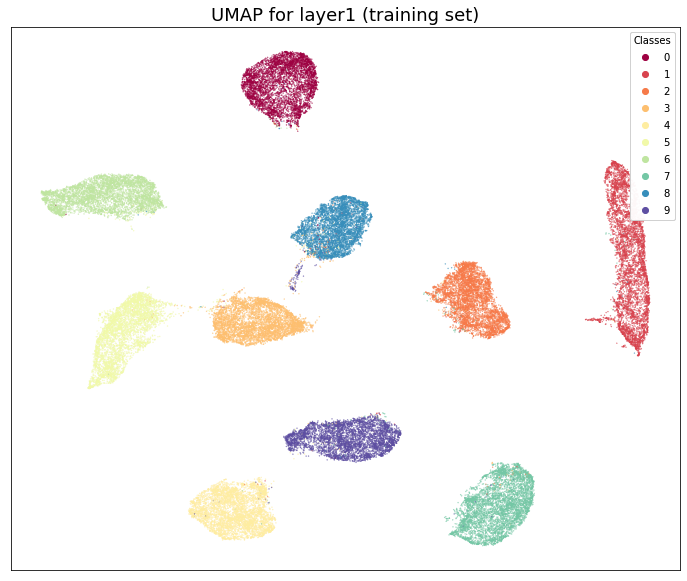

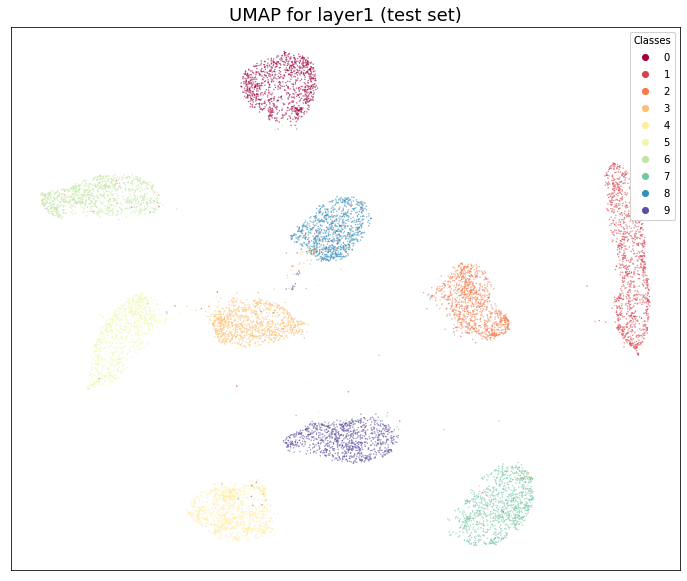

In [23]:
layer1_umap = umap.UMAP(random_state=42)
embedding_umap_layer1 = layer1_umap.fit_transform(layer1_output) 
embedding_umap_layer1_test = layer1_umap.transform(test_layer1_output)

method_vis(embedding_umap_layer1, Y_train, 'UMAP for layer1 (training set)')
method_vis(embedding_umap_layer1_test, Y_test, 'UMAP for layer1 (test set)')

Wizualizacja pokazuje bardzo dobrą seperację pomiędzy wszystkimi klasami. Ponownie klasy odpowiadające cyfrom 9, 7, 4 oraz 3, 5, 8 są bliżej siebie niż pozostałe, jednak są znacznie lepiej odseperowane.\
Ponownie zbiory trenigowy, na którym trenowany był model, jak i testowy tworzą bardzo podobą wizualizację.

**Wizualizacja częsci treningowej i testowej danych wyjściowych z drugiej warstwy sieci neuronowej przetworzonych przy użyciu UMAP**

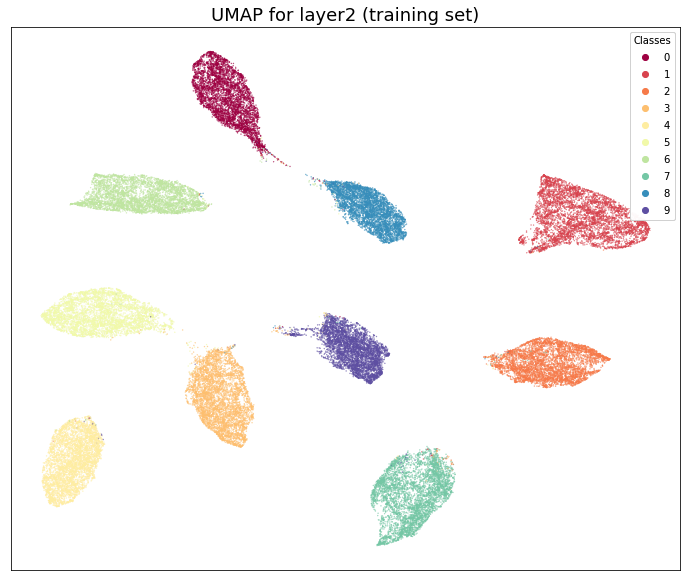

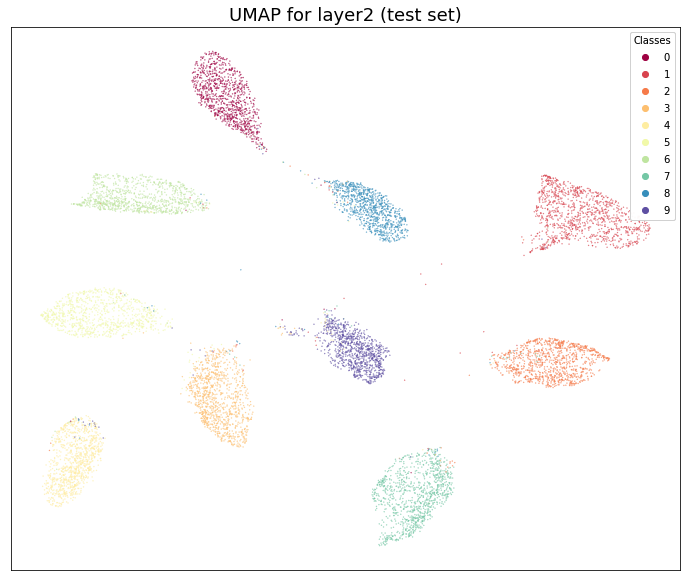

In [24]:
layer2_umap = umap.UMAP(random_state=42)
embedding_umap_layer2 = layer2_umap.fit_transform(layer2_output)
embedding_umap_layer2_test = layer2_umap.transform(test_layer2_output)

method_vis(embedding_umap_layer2, Y_train, 'UMAP for layer2 (training set)')
method_vis(embedding_umap_layer2_test, Y_test, 'UMAP for layer2 (test set)')

Wizualizacja pokazuje najlepszą z dotychczas uzyskanych seperacji pomiędzy wszystkimi klasami. Wszystkie klasy są w niemalże jednakowych odległościach.\
Ponownie zbiory trenigowy, na którym trenowany był model, jak i testowy tworzą bardzo podobą wizualizację.

### TSNE

**Wizualizacja częsci treningowej danych wejściowych przetworzonych przy użyciu t-SNE**

TSNE is a non-linear, non-parametric embedding, so there is no possibility to use already learned t-SNE to transform new points into the existing embedded space. 

Training part projection using TSNE.
TSNE is a non-linear, non-parametric embedding, so there is no possibility to use already learned t-SNE to transform new points into the existing embedded space. 

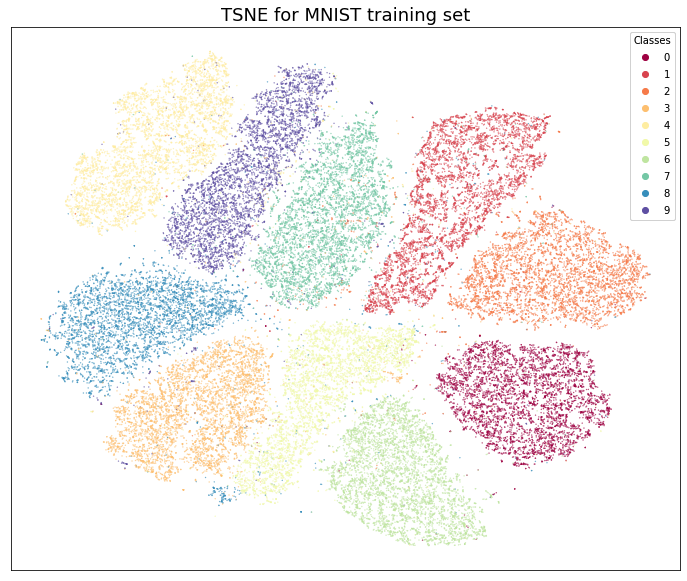

In [25]:
reducer_tsne_mnist = TSNE(n_components=2, metric='euclidean')
embedding_mnist_tsne = reducer_tsne_mnist.fit_transform(X_train)

method_vis(embedding_mnist_tsne, Y_train, 'TSNE for MNIST training set')

Wizualizacja pokazuje dobrą seperację pomiędzy klasami, jednak granice poszczególnych klas są bardzo rozmyte, a klasy odpowiadające cyfrom 3 i 8 przenikają się oraz widać pojedyncze elementy znajdujące się w obrębie nie swoich klas.

### TSNE for hidden **layers**

**Wizualizacja częsci treningowej i testowej danych wyjściowych z pierwszej warstwy sieci neuronowej przetworzonych przy użyciu t-SNE**

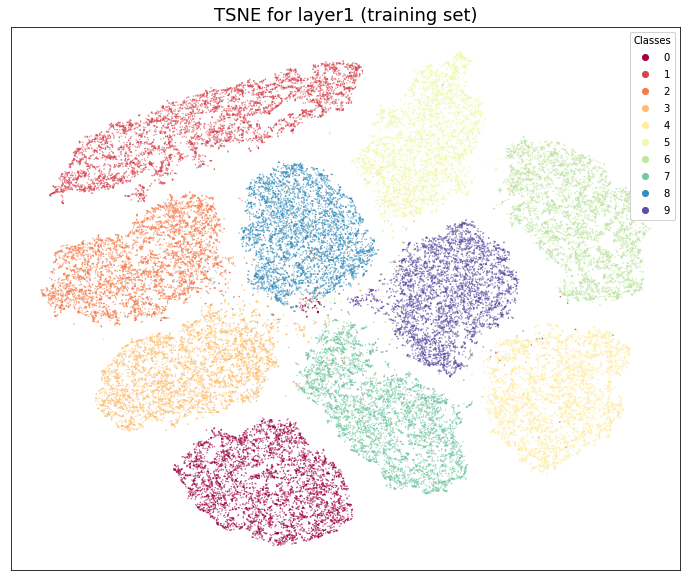

In [26]:
layer1_tsne = TSNE(n_components=2, metric='euclidean', perplexity=35)
embedding_tsne_layer1 = layer1_tsne.fit_transform(layer1_output) 

method_vis(embedding_tsne_layer1, Y_train, 'TSNE for layer1 (training set)')

Wizualizacja pokazuje lepszą seperację pomiędzy klasami niż poprzedni przykład, granice poszczególnych klas są mniej rozmyte, a klasy odpowiadające cyfrom 3 i 8 nie przenikają przenikają się.

**Wizualizacja części treningowej i testowej danych wyjściowych z drugiej warstwy sieci neuronowej przetworzonych przy użyciu t-SNE**

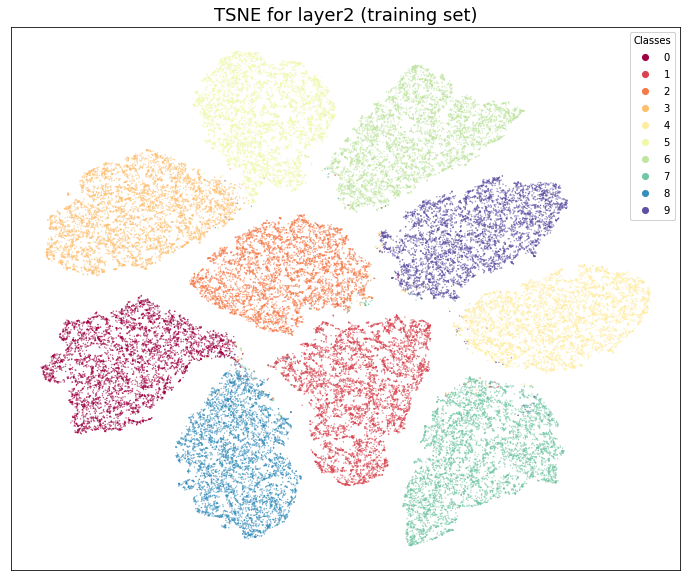

In [27]:
layer2_tsne = TSNE(n_components=2, metric='euclidean', perplexity=35)
embedding_tsne_layer2 = layer2_tsne.fit_transform(layer2_output) 

method_vis(embedding_tsne_layer2, Y_train, 'TSNE for layer2 (training set)')

Wizualizacja pokazuje najlepszą seperację spośród wszystkich porównywanych dla metody t-SNE. Granice poszczególnych klas bardzo ostre, znacznie mniej elementów wybiega poza granice swoich klas.

In [31]:
# calculating accuracies

### K-nearest neighbours

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def knnScore(x_train, y_train, x_test ,y_test, n_neighbors,metric="euclidean"):
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
    neigh.fit(x_train, y_train)
    predicted = neigh.predict(x_test)
    return accuracy_score(y_test, predicted)

In [57]:
kns = [3,5,10,15,20,30]
metrics = ["euclidean","manhattan","chebyshev"]

#### Reduced mnist data

In [65]:
from pandas import DataFrame
raw_accuracies = [[knnScore(embedding_umap_mnist, Y_train, embedding_umap_mnist_test, Y_test, i,metric) for metric in metrics] for i in kns]
raw_knn_dt = DataFrame(index=kns,columns=metrics,data=raw_accuracies)
raw_knn_dt.head()

,euclidean,manhattan,chebyshev
3,0.9490,0.9495,0.9490
5,0.9525,0.9530,0.9529
10,0.9534,0.9535,0.9534
15,0.9540,0.9542,0.9538
20,0.9533,0.9535,0.9532


#### Data from first layer

In [71]:
layer_1_accuracies = [[knnScore(embedding_umap_layer1, Y_train, embedding_umap_layer1_test, Y_test, i,metric) for metric in metrics] for i in kns]
layer_1_knn_dt = DataFrame(index=kns,columns=metrics,data=layer_1_accuracies)
layer_1_knn_dt.head()

,euclidean,manhattan,chebyshev
3,0.9665,0.9663,0.9669
5,0.9679,0.9679,0.9677
10,0.9680,0.9681,0.9678
15,0.9681,0.9682,0.9679
20,0.9679,0.9678,0.9682


#### Data from second layer

In [72]:
layer_2_accuracies = [[knnScore(embedding_umap_layer2, Y_train, embedding_umap_layer2_test, Y_test, i,metric) for metric in metrics] for i in kns]
layer_2_knn_dt = DataFrame(index=kns,columns=metrics,data=layer_2_accuracies)
layer_2_knn_dt.head()

,euclidean,manhattan,chebyshev
3,0.9740,0.9736,0.9741
5,0.9745,0.9741,0.9746
10,0.9743,0.9745,0.9741
15,0.9750,0.9750,0.9751
20,0.9748,0.9748,0.9748
